In [31]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import matplotlib as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from nltk.corpus import stopwords
import nltk


mass_words = []
messages = pd.read_csv("messages.csv", encoding="utf-8")
messages = messages[["id", "text"]]
messages.head()


labels = pd.read_csv("labels.csv", encoding="utf-8")
labels = labels[["id","label"]]
labels.head()

nltk.download('stopwords')

stop = set(stopwords.words("russian"))

def remove_stop_words(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)

messages["text"] = messages["text"].map(remove_stop_words)
df = messages
df["label"] = labels["label"].values

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/taranyuriy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Чистим данные

In [43]:
from sklearn.model_selection import train_test_split 

df_task = df[df["label"]=="task"]
df_task.shape

df_event = df[df["label"]=="event"]
df_event.shape

df_other = df[df["label"]=="other"]
df_other.shape

df_event_sample = df_event.sample(df_task.shape[0])
df_event_sample.shape

df_other_sample = df_other.sample(df_task.shape[0])
df_other_sample.shape

df_balanced = pd.concat([df_event_sample, df_other_sample,df_task])
df_balanced.shape
df_balanced["label"].value_counts()

df_balanced['label'] = df_balanced['label'].map({'other': 0, 'task': 1, 'event':2})
feature_extraction = TfidfVectorizer()
X = feature_extraction.fit_transform(df_balanced["text"].values)
X_train, X_test, y_train, y_test = train_test_split(X, df_balanced["label"].values, stratify=df_balanced["label"])

In [44]:
from sklearn.metrics import hinge_loss
sel = RandomForestClassifier(n_estimators=100)
sel.fit(X_train, y_train)

# train classifier
svr = SVC(probability=True, kernel='rbf')
svr.fit(X_train, y_train)

predictions = sel.predict_proba(X_test)
preds = svr.predict_proba(X_test)

print('Rabdom forest - ROC-AUC yields ' + str(roc_auc_score(y_test, predictions,multi_class='ovr')))
print('SVM - ROC-AUC yields ' + str(roc_auc_score(y_test, preds,multi_class='ovr')))

loss = hinge_loss(y_test, svr.decision_function(X_test))
print("Hinge Loss:", loss)
# confusion_matrix(y_test, preds, labels=["task", "event", "other"])

Rabdom forest - ROC-AUC yields 0.9642254355750967
SVM - ROC-AUC yields 0.9665984137817918
Hinge Loss: 0.2960931055128362


Confusion matrix, without normalization
[[236  12   3]
 [ 43 196  12]
 [ 19   4 228]]
Normalized confusion matrix
[[0.94023904 0.04780876 0.01195219]
 [0.17131474 0.78087649 0.04780876]
 [0.07569721 0.01593625 0.90836653]]


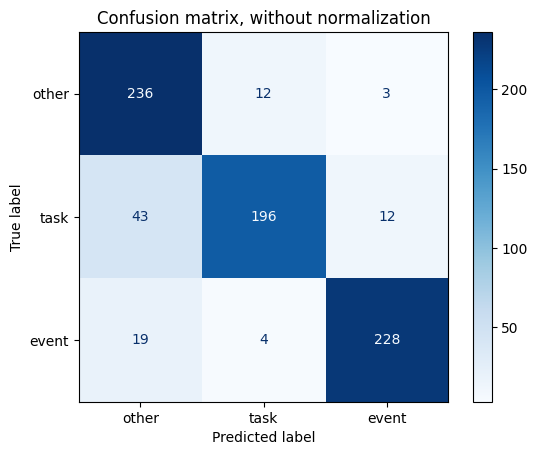

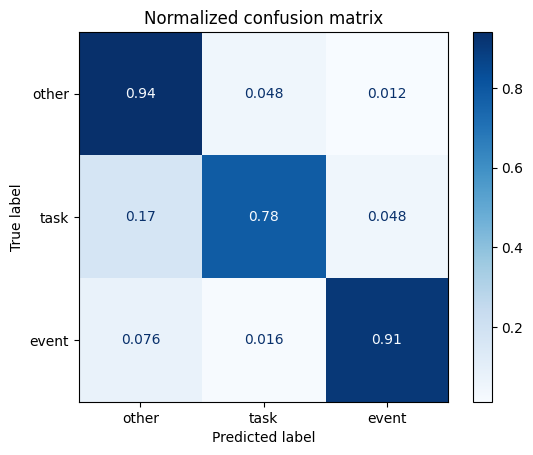

In [51]:
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# accuracy = roc_auc_score(y_test, preds,multi_class='ovr')
# Step 4: Calculate loss (if applicable)

# # Step 5: Store accuracy and loss values
# accuracy_values = []
# loss_values = []

# # Store accuracy for each iteration or epoch
# accuracy_values.append(accuracy)

# # Store loss for each iteration or epoch (if applicable)
# loss_values.append(loss)

# # Step 6: Plot the results
# plt.plot(accuracy_values, label='Accuracy')
# plt.plot(loss_values, label='Loss')
# plt.xlabel('Iterations/Epochs')
# plt.ylabel('Accuracy/Loss')
# plt.legend()
# plt.show()threshold = 0.5
threshold = 0.5
# Convert probabilities to predicted labels
y_preds = np.argmax(preds, axis=1)
y_preds = np.where(np.max(preds, axis=1) >= threshold, y_preds, -1)
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svr,
        X_test,
        y_test,
        display_labels=["other", "task", "event"],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
# print(classification_report(y_test, y_preds))
# confusion_matrix(y_test, y_preds)

In [11]:
# import matplotlib.pyplot as plt


# def plot_graphs(history, metric):
#   plt.plot(history.history[metric])
#   plt.plot(history.history['val_'+metric], '')
#   plt.xlabel("Epochs")
#   plt.ylabel(metric)
#   plt.legend([metric, 'val_'+metric])

(3442, 3)